In [ ]:
remote = "https://raw.githubusercontent.com/nansencenter/DA-tutorials"
!wget -qO- {remote}/master/notebooks/resources/colab_bootstrap.sh | bash -s
import resources.workspace as ws

In [18]:
import numpy as np
import matplotlib as mpl
import numpy.random as rnd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
plt.ion();

# T9 - Writing your own EnKF
In this tutorial we're going to code an EnKF implementation using numpy.
As with the KF, the EnKF consists of the recursive application of
a forecast step and an analysis step.
$
% ######################################## Loading TeX (MathJax)... Please wait ########################################
\newcommand{\Reals}{\mathbb{R}} \newcommand{\Expect}[0]{\mathbb{E}} \newcommand{\NormDist}{\mathcal{N}} \newcommand{\DynMod}[0]{\mathscr{M}} \newcommand{\ObsMod}[0]{\mathscr{H}} \newcommand{\mat}[1]{{\mathbf{{#1}}}} \newcommand{\bvec}[1]{{\mathbf{#1}}} \newcommand{\trsign}{{\mathsf{T}}} \newcommand{\tr}{^{\trsign}} \newcommand{\ceq}[0]{\mathrel{≔}} \newcommand{\xDim}[0]{D} \newcommand{\supa}[0]{^\text{a}} \newcommand{\supf}[0]{^\text{f}} \newcommand{\I}[0]{\mat{I}} \newcommand{\K}[0]{\mat{K}} \newcommand{\bP}[0]{\mat{P}} \newcommand{\bH}[0]{\mat{H}} \newcommand{\bF}[0]{\mat{F}} \newcommand{\R}[0]{\mat{R}} \newcommand{\Q}[0]{\mat{Q}} \newcommand{\B}[0]{\mat{B}} \newcommand{\C}[0]{\mat{C}} \newcommand{\Ri}[0]{\R^{-1}} \newcommand{\Bi}[0]{\B^{-1}} \newcommand{\X}[0]{\mat{X}} \newcommand{\A}[0]{\mat{A}} \newcommand{\Y}[0]{\mat{Y}} \newcommand{\E}[0]{\mat{E}} \newcommand{\U}[0]{\mat{U}} \newcommand{\V}[0]{\mat{V}} \newcommand{\x}[0]{\bvec{x}} \newcommand{\y}[0]{\bvec{y}} \newcommand{\z}[0]{\bvec{z}} \newcommand{\q}[0]{\bvec{q}} \newcommand{\br}[0]{\bvec{r}} \newcommand{\bb}[0]{\bvec{b}} \newcommand{\bx}[0]{\bvec{\bar{x}}} \newcommand{\by}[0]{\bvec{\bar{y}}} \newcommand{\barB}[0]{\mat{\bar{B}}} \newcommand{\barP}[0]{\mat{\bar{P}}} \newcommand{\barC}[0]{\mat{\bar{C}}} \newcommand{\barK}[0]{\mat{\bar{K}}} \newcommand{\D}[0]{\mat{D}} \newcommand{\Dobs}[0]{\mat{D}_{\text{obs}}} \newcommand{\Dmod}[0]{\mat{D}_{\text{obs}}} \newcommand{\ones}[0]{\bvec{1}} \newcommand{\AN}[0]{\big( \I_N - \ones \ones\tr / N \big)}
$

This presentation follows the traditional template, presenting the EnKF as the "the Monte Carlo version of the KF
where the state covariance is estimated by the ensemble covariance".
It is not obvious that this postulated method should work;
indeed, it is only justified upon inspection of its properties,
deferred to later.

<mark><font size="-1">
<b>NB:</b>
Since we're going to focus on a single filtering cycle (at a time),
the subscript $k$ is dropped. Moreover, <br>
The superscript $f$ indicates that $\{\x_n\supf\}_{n=1..N}$ is the forecast (prior) ensemble.<br>
The superscript $a$ indicates that $\{\x_n\supa\}_{n=1..N}$ is the analysis (posterior) ensemble.
</font></mark>

### The forecast step
Suppose $\{\x_n\supa\}_{n=1..N}$ is an iid. sample from $p(\x_{k-1} \mid \y_1,\ldots, \y_{k-1})$, which may or may not be Gaussian.

The forecast step of the EnKF consists of a Monte Carlo simulation
of the forecast dynamics for each $\x_n\supa$:
$$
	\forall n, \quad \x\supf_n = \DynMod(\x_n\supa) + \q_n  \, , \\
$$
where $\{\q_n\}_{n=1..N}$ are sampled iid. from $\NormDist(\bvec{0},\Q)$,
or whatever noise model is assumed,  
and $\DynMod$ is the model dynamics.
The dynamics could consist of *any* function, i.e. the EnKF can be applied with nonlinear models.

The ensemble, $\{\x_n\supf\}_{n=1..N}$, is then an iid. sample from the forecast pdf,
$p(\x_k \mid \y_1,\ldots,\y_{k-1})$. This follows from the definition of the latter, so it is a relatively trivial idea and way to obtain this pdf. However, before Monte-Carlo methods were computationally feasible, the computation of the forecast pdf required computing the [Chapman-Kolmogorov equation](https://en.wikipedia.org/wiki/Chapman%E2%80%93Kolmogorov_equation), which constituted a major hurdle for filtering methods.

### The analysis update step
of the ensemble is given by:
$$\begin{align}
	\forall n, \quad \x\supa_n &= \x_n\supf + \barK \left\{\y - \br_n - \ObsMod(\x_n\supf) \right\}
	\, , \\
	\text{or,}\quad
	\E\supa &=  \E\supf  + \barK \left\{\y\ones\tr - \Dobs - \ObsMod(\E\supf)  \right\} \, ,
    \tag{4}
\end{align}
$$
where the "observation perturbations", $\br_n$, are sampled iid. from the observation noise model, e.g. $\NormDist(\bvec{0},\R)$,  
and form the columns of $\Dobs$,  
and the observation operator (again, any type of function) $\ObsMod$ is applied column-wise to $\E\supf$.

The gain $\barK$ is defined by inserting the ensemble estimates for
 * (i) $\B \bH\tr$: the cross-covariance between $\x\supf$ and $\ObsMod(\x\supf)$, and
 * (ii) $\bH \B \bH\tr$: the covariance matrix of $\ObsMod(\x\supf)$,

in the formula for $\K$, namely eqn. (K1) of [T5](T5%20-%20Kalman%20filter%20(multivariate).ipynb).
Using the estimators from [T8](T8%20-%20Monte-Carlo%20%26%20ensembles.ipynb) yields
$$\begin{align}
	\barK &= \X \Y\tr ( \Y \Y\tr + (N{-}1) \R )^{-1} \, , \tag{5a}
\end{align}
$$
where $\Y \in \Reals^{P \times N}$
is the centered, *observed* ensemble
$\Y \ceq
\begin{bmatrix}
		\y_1 -\by, & \ldots & \y_n -\by, & \ldots & \y_N -\by
	\end{bmatrix} \, ,$ where $\y_n = \ObsMod(\x_n\supf)$.

The EnKF is summarized in the animation below.

In [ ]:
ws.EnKF_animation()

#### Exc -- Woodbury for the ensemble subspace
(a) Use the Woodbury identity (C2) of [T5](T5%20-%20Kalman%20filter%20(multivariate).ipynb) to show that eqn. (5) can also be written
$$\begin{align}
	\barK &= \X ( \Y\tr \Ri \Y + (N{-}1)\I_N  )^{-1} \Y\tr \Ri \, . \tag{5b}
\end{align}
$$
(b) What is the potential benefit?

#### Exc -- KG workings
The above animation assumed that the observation operator is just the identity matrix, $\I$, rather than a general observation operator, $\ObsMod()$. Meanwhile, the Kalman gain used by the EnKF, eqn. (5a), is applicable for any $\ObsMod()$. On the other hand, the formula (5a) consists solely of linear algebra. Therefore it cannot perfectly represent any general (nonlinear) $\ObsMod()$. So how does it actually treat the observation operator? What meaning can we assign to the resulting updates?  
*Hint*: consider the limit of $\R \rightarrow 0$.

#### Exc -- EnKF nobias (a)
Consider the ensemble averages,
 - $\bx\supa = \frac{1}{N}\sum_{n=1}^N \x\supa_n$, and
 - $\bx\supf = \frac{1}{N}\sum_{n=1}^N \x\supf_n$,

and recall that the analysis step, eqn. (4), defines $\x\supa_n$ from $\x\supf_n$.


(a) Show that, in case $\ObsMod$ is linear (the matrix $\bH$),
$$\begin{align}
	\Expect \bx\supa &=  \bx\supf  + \barK \left\{\y\ones\tr - \bH\bx\supf  \right\} \, , \tag{6}
\end{align}
$$
where the expectation, $\Expect$, is taken with respect to $\Dobs$ only (i.e. not the sampling of the forecast ensemble, $\E\supf$ itself).

What does this mean?

In [ ]:
# ws.show_answer("EnKF_nobias_a")

#### Exc (optional) -- EnKF nobias (b)
Consider the ensemble covariance matrices:
$$\begin{align}
\barB &= \frac{1}{N-1} \X{\X}\tr \, , \tag{7a} \\\
\barP &= \frac{1}{N-1} \X\supa{\X\supa}\tr \, . \tag{7b}
\end{align}$$

Now, denote the centralized observation perturbations:
$$\begin{align}
\D &= \Dobs - \bar{\br}\ones\tr \\\
&= \Dobs\AN \, . \tag{8}
\end{align}$$
Note that $\D \ones = \bvec{0}$ and, with expectation over $\Dobs$,
$$
\begin{align}
	\label{eqn:R_sample_cov_of_D}
	\frac{1}{N-1}\D \D\tr = \R \, , \tag{9a} \\\
	\label{eqn:zero_AD_cov}
	\X \D\tr = \bvec{0} \, . \tag{9b}
\end{align}
$$
Assuming eqns (8) and (9) hold true, show that
$$\begin{align}
    \barP &= [\I_{\xDim} - \barK \bH]\barB \, . \tag{10}
\end{align}$$

In [ ]:
# ws.show_answer("EnKF_nobias_b")

#### Exc (optional) -- EnKF bias (c)
Show that, if no observation perturbations are used in eqn. (4), then $\barP$ would be too small.

In [ ]:
# ws.show_answer("EnKF_without_perturbations")

## Experimental setup

Before making the EnKF, we'll set up an experiment to test it with, so that you can check if you've implemented a working method or not.

To that end, we'll use the Lorenz-63 model, from [T7](T7%20-%20Chaos%20%26%20Lorenz.ipynb). The coupled ODEs are recalled here, but with some of the parameters fixed.

In [ ]:
xDim = 3

def dxdt(x, sig=10, rho=28, beta=8/3):
    x,y,z = x
    d = np.zeros(3)
    d[0] = sig*(y - x)
    d[1] = rho*x - y - x*z
    d[2] = x*y - beta*z
    return d

Next, we make the forecast model $\DynMod$ out of $\frac{d \x}{dt}$ such that $\x(t+dt) = \DynMod(\x(t),t,dt)$. We'll make use of the "4th order Runge-Kutta" integrator `rk4`.

In [ ]:
from dapper.mods.integration import rk4

def Dyn(E, t0, dt):

    def step(x0):
        return rk4(lambda x, t: dxdt(x), x0, t0, dt)

    if E.ndim == 1:
        # Truth (single state vector) case
        E = step(E)
    else:
        # Ensemble case
        for n in range(E.shape[1]):
            E[:, n] = step(E[:, n])

    return E

Q12 = np.zeros((xDim, xDim))
Q = Q12 @ Q12.T

Notice the loop over each ensemble member. For better performance, this should be vectorized, if possible. Or, if the forecast model is computationally demanding (as is typically the case in real applications), the loop should be parallelized: i.e. the forecast simulations should be distributed to separate computers.

The following are the time settings that we will use

In [ ]:
dt = 0.01           # integrational time step
dko = 25            # number of steps between observations
dto = dko*dt        # time between observations
Ko = 60             # total number of observations
nTime = dko*(Ko+1)  # total number of time steps

Initial conditions

In [ ]:
xa = np.array([1.509, -1.531, 25.46])
Pa12 = np.eye(3)

Observation model settings

In [ ]:
p = 3 # ndim obs
def Obs(E, t):
    return E[:p] if E.ndim == 1 else E[:p, :]

R12 = np.sqrt(2)*np.eye(p)
R = R12 @ R12.T

Generate synthetic truth and observations

In [ ]:
# Init
truths = np.zeros((nTime+1, xDim))
obsrvs = np.zeros((Ko+1, p))
truths[0] = xa + Pa12 @ rnd.randn(xDim)

In [ ]:
# Loop
for k in range(1, nTime+1):
    truths[k] = Dyn(truths[k-1], (k-1)*dt, dt)
    truths[k] += Q12 @ rnd.randn(xDim)
    if k % dko == 0:
        Ko = k//dko-1
        obsrvs[Ko] = Obs(truths[k], np.nan) + R12 @ rnd.randn(p)

## EnKF implementation

We will make use of `estimate_mean_and_cov` and `estimate_cross_cov` from the previous section. Paste them in below.

In [ ]:
# def estimate_mean_and_cov ...

**Exc -- EnKF implementation:** Complete the code below

In [19]:
# Useful linear algebra: compute B/A
import numpy.linalg as nla

ens_means = np.zeros((nTime+1, xDim))
ens_vrncs = np.zeros((nTime+1, xDim))

def my_EnKF(N):
    """My implementation of the EnKF."""
    ### Init ###
    E = np.zeros((xDim, N))
    for k in tqdm(range(1, nTime+1)):
        t = k*dt
        ### Forecast ##
        # E = ...  # use model
        # E = ...  # add noise
        if k % dko == 0:
            ### Analysis ##
            y = obsrvs[[k//dko-1]].T  # current observation
            Eo = Obs(E, t)            # observed ensemble
            # Compute ensemble moments
            PH = ...
            HPH = ...
            # Compute Kalman Gain
            KG = ...
            # Generate perturbations
            Perturb = ...
            # Update ensemble with KG
            # E = ...
        # Save statistics
        ens_means[k] = np.mean(E, axis=1)
        ens_vrncs[k] = np.var(E, axis=1, ddof=1)

Notice that we only store some stats (`ens_means`). This is because in large systems,
keeping the entire ensemble (or its covariance) in memory is probably too much.

In [20]:
# ws.show_answer('EnKF v1')

Now let's try out its capabilities

  0%|          | 0/1525 [00:00<?, ?it/s]

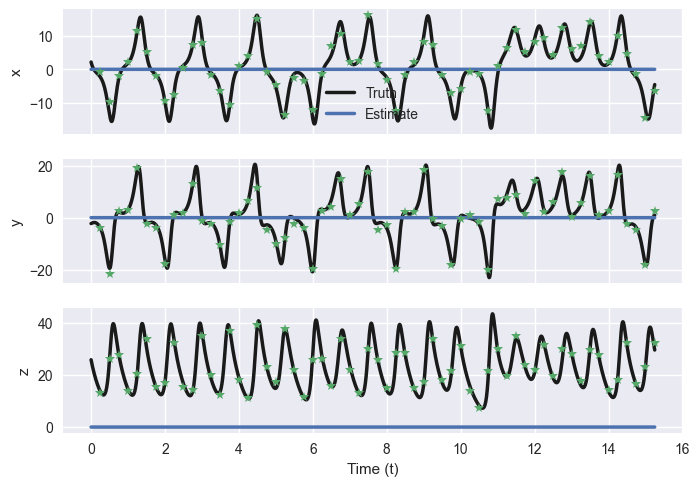

In [22]:
# Run assimilation
my_EnKF(10)

# Plot
fig, axs = plt.subplots(nrows=3, sharex=True)
for i in range(3):
    axs[i].plot(dt*np.arange(nTime+1), truths   [:, i], 'k', label="Truth")
    axs[i].plot(dt*np.arange(nTime+1), ens_means[:, i], 'b', label="Estimate")
    if i<p:
        axs[i].plot(dto*np.arange(1, Ko+2), obsrvs[:, i], 'g*')
    axs[i].set_ylabel(f"{'xyz'[i]}")
axs[0].legend()
plt.xlabel("Time (t)");

**Exc -- Diagnostics:** The visuals of the plots are nice. But it would be good to have a summary statistic of the accuracy performance of the filter. Make a function `average_rmse(truths, means)` that computes $ \frac{1}{K+1} \sum_{k=0}^K \sqrt{\frac{1}{\xDim} \| \bx_k - \x_k \|_2^2} \, .$

In [ ]:
def average_rmse(truth, estimates):
    ### INSERT ANSWER ###
    average = ...
    return average

# Test
average_rmse(truths, ens_means)

In [ ]:
# ws.show_answer('rmse')

**Exc -- Experiment variations:**
 * (a). Repeat the above experiment, but now observing only the first (0th) component of the state.

In [ ]:
# ws.show_answer('Repeat experiment a')

 * (b). Put a `seed()` command in the right place so as to be able to recreate exactly the same results from an experiment.

In [ ]:
# ws.show_answer('Repeat experiment b')

 * (c). Use $N=5$, and repeat the experiments. This is quite a small ensemble size, and quite often it will yield divergence: the EnKF "definitely loses track" of the truth, typically because of strong nonlinearity in the forecast models, and underestimation (by $\barP)$ of the actual errors. Repeat the experiment with different seeds until you observe in the plots that divergence has happened.
 * (d). Implement "multiplicative inflation" to remedy the situation; this is a factor that should spread the ensemble further apart; a simple version is to inflate the perturbations. Implement it, and tune its value to try to avoid divergence.

In [ ]:
# ws.show_answer('Repeat experiment cd')